In [61]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

Feel free to experiment with different pool csv's. Beware: many rides means messy visualizations!

In [62]:
input_data = pd.read_csv("./data/output/taxi_data_20190101_121000.csv",index_col=0, parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
interzonal_dist = pd.read_csv("./data/interzonal.csv")

In [63]:
input_data.head()

,id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,PULocationID,DOLocationID
0,93377,2019-01-01 12:10:03,2019-01-01 12:31:42,1,138,151
1,93890,2019-01-01 12:10:08,2019-01-01 12:55:59,1,161,138
2,88297,2019-01-01 12:10:08,2019-01-01 12:35:24,1,138,163
3,92953,2019-01-01 12:10:23,2019-01-01 12:37:29,1,230,138
4,91843,2019-01-01 12:10:23,2019-01-01 12:34:14,2,138,65


In [64]:
interzonal_dist.head()

,0,1,2,3,4,5,6,7,8,9,...,253,254,255,256,257,258,259,260,261,262
0,0.0,46390.2,56813.2,34410.0,13834.9,13256.2,40598.2,41862.0,50006.8,46375.7,...,58781.9,34403.2,33748.3,23309.2,43392.1,60676.5,39255.3,29611.7,41990.4,42506.5
1,46340.8,0.0,33936.3,22108.1,49248.5,33819.3,28398.1,28693.7,21076.1,12127.1,...,36534.7,19707.0,19219.8,18987.1,8917.7,38555.3,18936.4,26857.9,26713.8,27229.9
2,58987.0,35229.4,0.0,25979.5,61894.8,46453.8,16981.5,16956.5,16807.1,25213.3,...,3008.8,28687.9,28788.4,36915.2,25550.7,5237.2,22664.8,29779.4,18016.7,18532.8
3,33650.0,22875.7,22646.4,0.0,36557.8,21116.8,10092.7,10824.1,21550.5,25507.6,...,24615.1,5426.0,3701.1,13404.1,14596.3,26509.7,10471.6,5806.3,7823.5,8339.6
4,12559.6,49367.0,59790.1,37386.8,0.0,14894.5,43575.1,44838.9,52983.7,49352.6,...,61758.8,37380.0,36725.2,26286.1,46369.0,63653.4,42232.2,32588.6,44967.2,45483.4


Considering only the rows for LaGuaradia as pick-up

In [65]:
input_data_filter = input_data[input_data['PULocationID'] == 138]

In [73]:
input_data_filter["Distance"] = input_data_filter.apply(lambda row: interzonal_dist.iloc[row["PULocationID"]-1, row["DOLocationID"]-1], axis=1)
len(input_data_filter)

/home/harish/anaconda3/envs/adbms/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


30

Setting ID column as index for faster operations

In [67]:
input_data_filter.set_index("id", drop=True, inplace=True)

Creating a directed graph and adding nodes to it. Each node is just the ID number of the ride

In [68]:
DG = nx.Graph()
index_list = input_data_filter.index.tolist()
DG.add_nodes_from(index_list)

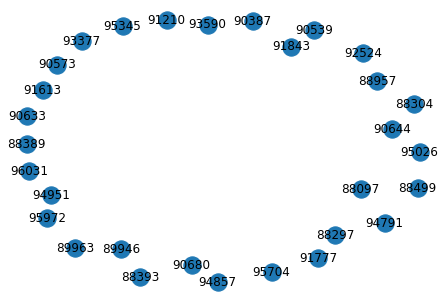

In [69]:
nx.draw(DG, with_labels=True)

The loop that adds edges and their corresponding weights to the graph. This is n^2.

In [70]:
for index1, index2 in combinations(index_list, 2):
    pool_size = 300 # 300 seconds
    max_passenger_count = 3
    
    # Passenger Count
    Pa = input_data_filter.loc[index1, "passenger_count"]
    Pb = input_data_filter.loc[index2, "passenger_count"]
    if(max_passenger_count - (Pa + Pb) < 0):
        continue


    # Distance Weight
    Da = input_data_filter.loc[index1, "Distance"]
    Db = input_data_filter.loc[index2, "Distance"]
    Dab = interzonal_dist.iloc[
        input_data_filter.loc[index1, "DOLocationID"]-1, 
        input_data_filter.loc[index2, "DOLocationID"]-1
    ]
    Dba = interzonal_dist.iloc[
        input_data_filter.loc[index2, "DOLocationID"]-1, 
        input_data_filter.loc[index1, "DOLocationID"]-1
    ]
    
    Dmin = min(Da + Dab, Db + Dba)
    distance_savings = Da + Db - Dmin
    weight = distance_savings / (Da + Db)

    # Arrival Time Weight: 
    Ta = input_data_filter.loc[index1, "tpep_pickup_datetime"]
    Tb = input_data_filter.loc[index2, "tpep_pickup_datetime"]
    Tab = abs(Tb - Ta).seconds
    weight += (pool_size - (Tab)) / pool_size

    DG.add_edge(index1, index2, weight=weight)


{(93377,
  88297): Text(0.6364733873985048, -0.24243952339737884, '1.2298581697606312'),
 (93377,
  91843): Text(0.8778421359428412, -0.1978862223050114, '0.8647836499261516'),
 (93377,
  88389): Text(0.6971846792160604, -0.10287388270535562, '1.1392907030498396'),
 (93377,
  96031): Text(0.7860155547826375, 0.3077334978707401, '0.8077188829166854'),
 (93377,
  90539): Text(0.6642475677501243, 0.16521244304029134, '1.0785709324535508'),
 (93377,
  88304): Text(0.39585056463677737, -0.16655310093064335, '1.0231915030939644'),
 (93377,
  89963): Text(0.7734098549592634, 0.09252331481439381, '0.7047836499261516'),
 (93377,
  90644): Text(0.3834102785165736, 0.23249422414209092, '0.6852031170747453'),
 (93377,
  95345): Text(0.7954271351214287, -0.023148160880700167, '0.8698024716103645'),
 (93377,
  94791): Text(0.4720062969961876, -0.2168526560315976, '0.9919419527358763'),
 (93377,
  88499): Text(0.6064029924913967, 0.419725294382999, '1.076128917419814'),
 (93377,
  92524): Text(0.5801

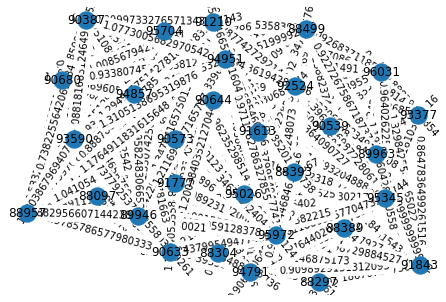

In [71]:
pos = nx.spring_layout(DG)
nx.draw(DG, pos, with_labels=True)
labels = nx.get_edge_attributes(DG, 'weight')
nx.draw_networkx_edge_labels(DG, pos, edge_labels=labels)

Both 1086 and 6606 are going to the same location, so the amount of distance saved is exactly 0.5. Does this make sense?

In [72]:
# DG.remove_edge(*next(iter(nx.algorithms.matching.max_weight_matching(DG))))
nx.algorithms.matching.max_weight_matching(DG)

{(88097, 91777),
 (88297, 93377),
 (88304, 88389),
 (88393, 91613),
 (88499, 94791),
 (88957, 94951),
 (90539, 89963),
 (90680, 90387),
 (91210, 93590),
 (91843, 96031),
 (94857, 89946),
 (95026, 90644),
 (95345, 92524),
 (95704, 90633),
 (95972, 90573)}